In [1]:
import numpy as np
import rasterio
import rasterio.mask
import geopandas as gpd
import os
from dem_utils_import import load_json, flat, th_vals, load_rast, plot_rast
from fundamental_functions_import import crop_raster

C:\Users\montse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Save properly tiff image

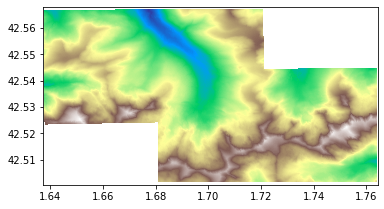

In [2]:
path_dem_saetde = 'C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/kram_files/inputs/dem_saetde.tif'

#Open base raster and modify the no_data_values
dem_base_array = th_vals.raster_threshold_to_nan(path_dem_saetde, nb_raster_band=1)

#Write in disk the array as a Geotiff file: 
dem_nodata_path = './notebook_outputs/rasters/dem_nodata.tif'

load_rast.write_raster_array(raster_array=dem_base_array, original_tif_path=path_dem_saetde, output_path=dem_nodata_path, nb_raster_band=1)

#Quick visualization of the written image
plot_rast.quick_show_rasterio(dem_nodata_path)


## Delete third coordinate in geojson

In [3]:
trails_path = 'C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/data/geo_data_saetde/trails_4326.geojson'
#Load the json file, and the geometry_recap of the json file
trails = load_json.load_json_file(trails_path)
trails_geometry = load_json.load_geom_json(trails)

#Delete Z-coordinate in the geojson file
trails_2d = flat.delete_z_coordinate(trails)

output_geojson_path = './notebook_outputs/shapefile/trails_2d_shapefile.geojson'
output_shapefile_path = './notebook_outputs/shapefile/trails_2d_shapefile.shp'

#Write into geojson format: 
load_json.write_geojson(trails_2d, output_geojson_path)

#Write into shp format: 
load_json.write_shp(output_geojson_path, output_shapefile_path)

## Crop the Baselayer with polygons

In [4]:
trails_path = 'C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/data/geo_data_saetde/trails_4326.geojson'
trails = crop_raster.flatten_raster_two_dim(output_geojson_path, output_shapefile_path, trails_geojson_path=trails_path)

In [12]:
#We first load the shapefile, and analyze its crs properties
shapefile_multi_poly = gpd.read_file(output_shapefile_path)
#We charge the dem image of saetde and we verify that they have the same crs properties
dem_path = 'C:/Users/montse/Desktop/ARI-Git/jupyterlab-data-science/src/kram_files/inputs/dem_saetde.tif'
dem_saetde = rasterio.open(dem_path)

print('DEM Saetde CRS: ', dem_saetde.crs,' / ', 'Shapefile CRS: ' ,shapefile_multi_poly.crs)

DEM Saetde CRS:  EPSG:4326  /  Shapefile CRS:  epsg:4326


In [13]:
file_path_my_masked = './notebook_outputs/rasters/dem_cropped.tif'
dem_nodata_path = './notebook_outputs/rasters/dem_nodata.tif'

In [14]:
#Remove mask file in order to rewrite:
my_masked = rasterio.open(file_path_my_masked)
my_masked_nodata = rasterio.open(dem_nodata_path)

  ##Only use it if we already have created the tif image; we can't rewrite it!
my_masked.close(); 
my_masked_nodata.close() # close the rasterio dataset
os.remove(file_path_my_masked); 
os.remove(dem_nodata_path)

In [15]:
#Crop shapefile into the raster_file: 
crop_raster.mask_by_shape(
  raster_file=dem_path,
  shape_file=output_shapefile_path,
  out_file_path=file_path_my_masked)

#Delete NoDataVal == 3.4e+38 and 
dem_saet = load_rast.open_raster_array(file_path_my_masked)
dem_array_nodata = np.where(dem_saet >= 3.399e+38, 0, dem_saet)
dem_array_nodata[dem_array_nodata == 0.] = np.nan

  #Write the proper raster without the NoDataValues: We use this method in order to only have the extent
  #of the slopes
load_rast.write_raster_rasterio(dem_array_nodata, path_dem_saetde, dem_nodata_path)

## Visualization of the cropped image

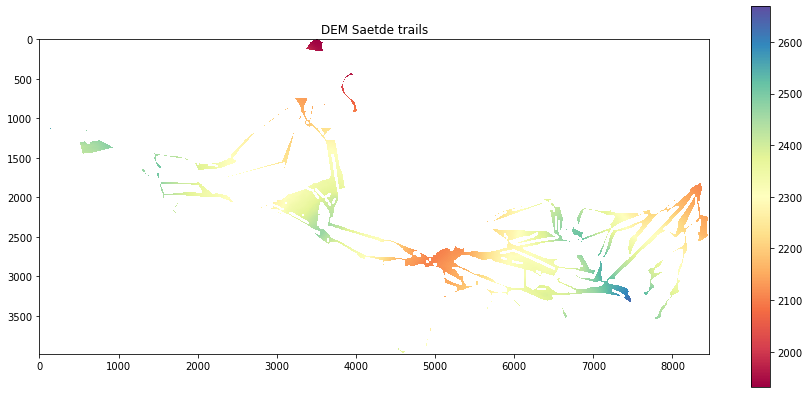

In [16]:
#Plot raster
saetde_slopes_img_path = './notebook_outputs/images/saetde_trails.png'
title = 'DEM Saetde trails'
plot_rast.plot_raster(dem_nodata_path, saetde_slopes_img_path, title, cmap='Spectral')

AttributeError: 'tuple' object has no attribute 'imshow'

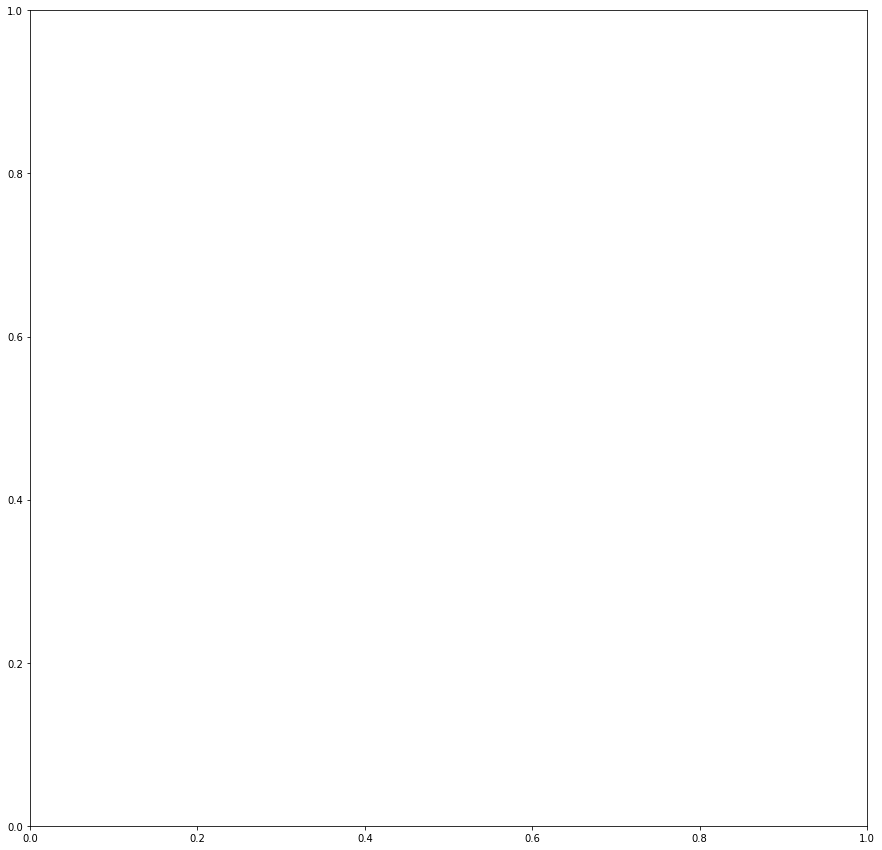

In [18]:
#Visualization of the cropped layer with the base layer: 
plot_rast.plot_base_layer_slopes(dem_nodata_path, output_shapefile_path)